# ML Classification - Random Forest
- Build Random Forest Classification Model
- Cross-Validation
- Hyperparameter Tuning
- Stratified Fold

# Key Features:
### Data Loading and Preprocessing:

- The script loads a heart-related dataset from a CSV file, handles missing values, and encodes categorical variables.
- Robust scaling is applied to continuous features.

### Model Training and Evaluation:

- Model evaluation includes accuracy, confusion matrix, and ROC AUC. Cross-validation is implemented for more robust performance assessment.

### Hyperparameter Tuning:

- Hyperparameter tuning is performed for RandomForestClassifier using GridSearchCV.

### Feature Importance (Tree-based Models):

- For tree-based models, feature importance is extracted and displayed.

### Model Saving:

- Trained models are saved using joblib for potential deployment.


In [1]:
try:
    import imblearn
except ImportError:
    print("imbalanced-learn not found. Installing...")
    !pip install imbalanced-learn
    print("imbalanced-learn installed successfully!")

# Now import and use imbalanced-learn
from imblearn.over_sampling import RandomOverSampler

In [2]:
# Importing necessary packages
import os
import shap
import numpy as np
import pandas as pd
import logging
import warnings
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import csv

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D
from matplotlib import cm
import matplotlib
from matplotlib import ticker
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as mtick
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from sklearn.calibration import calibration_curve
from scikitplot.metrics import plot_precision_recall
from sklearn.metrics import precision_recall_curve, auc
from scikitplot.metrics import plot_lift_curve
from scikitplot.metrics import plot_cumulative_gain
from sklearn.metrics import classification_report, roc_curve, accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score,StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.exceptions import ConvergenceWarning

from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
import joblib

import xgboost as xgb
import sqlite3


# Setting up options and ignoring warnings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('float_format', '{:f}'.format)
warnings.filterwarnings('ignore')

# Setting up logging with a FileHandler
log_file_path = 'classification_log.txt'
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', datefmt='%Y-%m-%d %H:%M:%S')

file_handler = logging.FileHandler(log_file_path)
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))

logger = logging.getLogger(__name__)
logger.addHandler(file_handler)

In [3]:
model_name='model.pkl'

# Reading the dataset
dataset_path = "/kaggle/input/heart.csv"

try:
    # Attempt to read the dataset
    df = pd.read_csv(dataset_path)
    logger.info(f"Dataset loaded successfully from {dataset_path}")
except FileNotFoundError:
    logger.error("Error: Dataset file not found. Please provide the correct file path.")
except Exception as e:
    logger.error(f"An error occurred: {e}")
    
df.head(2)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.300000,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.500000,0,0,2,1


In [4]:
# creating a copy of df
df1 = df.fillna(0)

# define the columns to be encoded and scaled
cat_cols = ['sex','exng','caa','cp','fbs','restecg','slp','thall']
con_cols = ["age","trtbps","chol","thalachh","oldpeak"]

#target column name
label_name = 'output'

# encoding the categorical columns
df1 = pd.get_dummies(df1, columns = cat_cols, drop_first = True)

# defining the features and target
X = df1.drop([label_name],axis=1)
y = df1[[label_name]]

In [5]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)
print("The shape of X_train is      ", X_train.shape)
print("The shape of X_test is       ",X_test.shape)
print("The shape of y_train is      ",y_train.shape)
print("The shape of y_test is       ",y_test.shape)

The shape of X_train is       (242, 22)
The shape of X_test is        (61, 22)
The shape of y_train is       (242, 1)
The shape of y_test is        (61, 1)


In [6]:
# Assuming y_train is your target variable
class_counts = y_train.value_counts()

# Print the counts
print("Class 0 count:", class_counts[0])
print("Class 1 count:", class_counts[1])

Class 0 count: 109
Class 1 count: 133


### For binary classification:
- accuracy: Calculates the accuracy of the classifier.
- precision': Measures the ability of the classifier not to label as positive a sample that is negative.
- recall: Measures the ability of the classifier to capture all the positive samples.
- f1: Combines precision and recall into a single metric.
- roc_auc: Computes the area under the Receiver Operating Characteristic (ROC) curve.

## Hyperparameter Tuning RandomForest

In [7]:
%%time

# Define the preprocessing pipeline with RobustScaler
preprocessor = Pipeline(steps=[('scaler', RobustScaler())])

# Define the Random Forest classifier
rf_clf = RandomForestClassifier()

# Define Stratified KFold for cross-validation
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Define the hyperparameters grid
param_grid = {
    'classifier__n_estimators': [2000, np.random.randint(10, 1000, 3)],
    'classifier__criterion': ['entropy'],
    'classifier__max_depth': [5,10,22,np.random.randint(1, 50, 3)],
    'classifier__min_samples_split': [1,2,3],
    'classifier__min_samples_leaf': [7,8],
    'classifier__class_weight': ['auto',{0:1,1:3},{0:1,1:2}],
    'classifier__random_state': [42],
    'classifier__warm_start': [True,False],
    'classifier__oob_score': [True,False]
}

# Define GridSearchCV with preprocessing pipeline
grid_search = GridSearchCV(estimator=Pipeline([('preprocessor', preprocessor), ('classifier', rf_clf)]),
                           param_grid=param_grid, cv=cv, n_jobs=-1, verbose=1, scoring='roc_auc')

# Fit GridSearchCV
grid_search.fit(X_train, y_train.values.ravel())

# Get the best estimator
best_estimator = grid_search.best_estimator_

# Print the mapping of class labels to actual class names
print("Class 0:", best_estimator.classes_[0])
print("Class 1:", best_estimator.classes_[1])

# Calculate additional evaluation metrics
y_pred = best_estimator.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# the scores
print("The best params are :", grid_search.best_params_)
print("The best score is   :", grid_search.best_score_)

# Save the model to disk
joblib.dump(grid_search.best_estimator_, model_name)

Fitting 2 folds for each of 576 candidates, totalling 1152 fits
Class 0: 0
Class 1: 1
Accuracy: 0.8524590163934426
Precision: 0.8108108108108109
Recall: 0.9375
F1-score: 0.8695652173913043
The best params are : {'classifier__class_weight': {0: 1, 1: 3}, 'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 7, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 2000, 'classifier__oob_score': True, 'classifier__random_state': 42, 'classifier__warm_start': True}
The best score is   : 0.8879349807436646
CPU times: user 11.5 s, sys: 994 ms, total: 12.5 s
Wall time: 6min 19s


['model.pkl']

## Application of SHAP Values
- Apart from machine learning interpretability and explainability, SHAP value can be used for:

- Model debugging. By examining the SHAP values, we can identify any biases or outliers in the data that may be causing the model to make mistakes.
- Feature importance. Identifying and removing low-impact features can create a more optimized model.
- Anchoring explanations. We can use SHAP values to explain individual predictions by highlighting the essential features that caused that prediction. It can help users understand and trust a model's decisions.
- Model summaries. It can provide a global summary of a model in the form of a SHAP value summary plot. It gives an overview of the most important features across the entire dataset.

- Detecting biases. The SHAP value analysis helps identify if certain features disproportionately affect particular groups. It enables the detection and reduction of discrimination in the model.
- Fairness auditing. It can be used to assess a model's fairness and ethical implications.
- Regulatory approval. SHAP values can help gain regulatory approval by explaining the model's decisions.

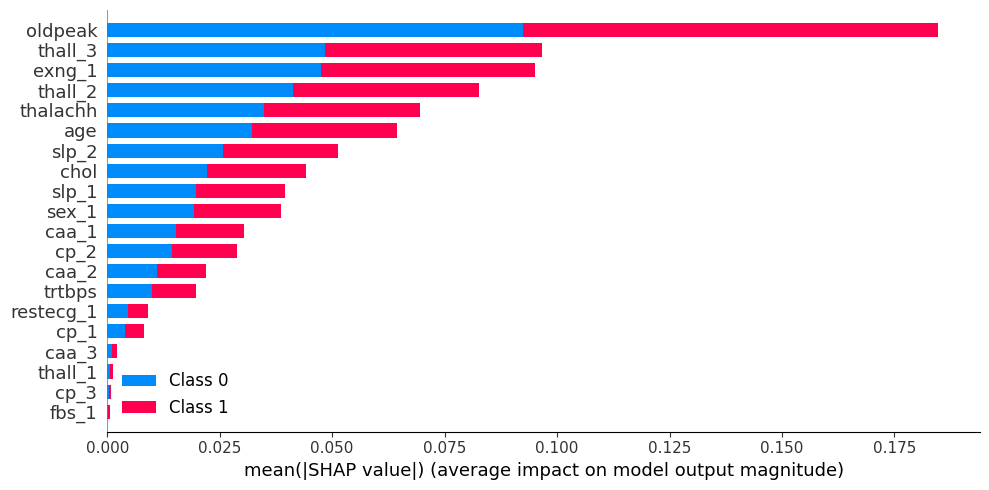

<Figure size 640x480 with 0 Axes>

In [8]:
# Explain the model predictions using SHAP
explainer = shap.Explainer(best_estimator.named_steps["classifier"])
shap_values = explainer.shap_values(X_test)

# Visualize the SHAP values
shap.summary_plot(shap_values, X_test, feature_names=X_train.columns, plot_size=(10, 5))

# Save the SHAP summary plot to a file
plt.savefig('shap_summary_plot1.png', bbox_inches='tight')

## Summary Plot
-Y-axis indicates the feature names in order of importance from top to bottom.
- X-axis represents the SHAP value, which indicates the degree of change in log odds.
- The color of each point on the graph represents the value of the corresponding feature, with red indicating high values and blue indicating low values.
- Each point represents a row of data from the original dataset.

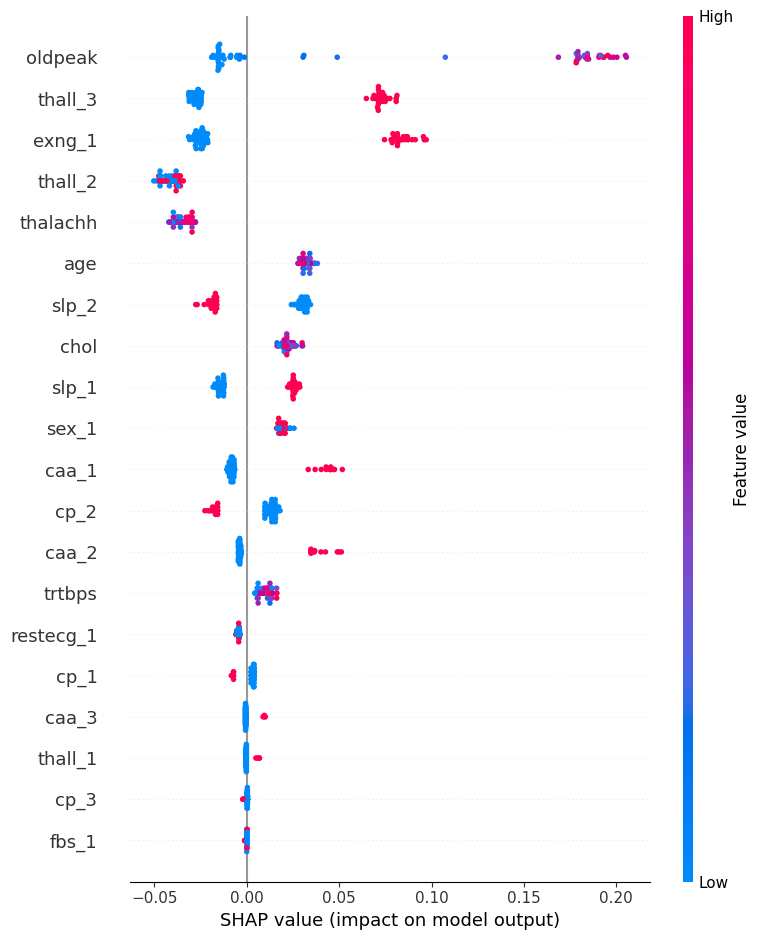

<Figure size 640x480 with 0 Axes>

In [9]:
shap.summary_plot(shap_values[0], X_test)
plt.savefig('shap_summary_plot2.png', bbox_inches='tight')

## Dependence Plot
-A dependence plot is a type of scatter plot that displays how a model's predictions are affected by a specific feature

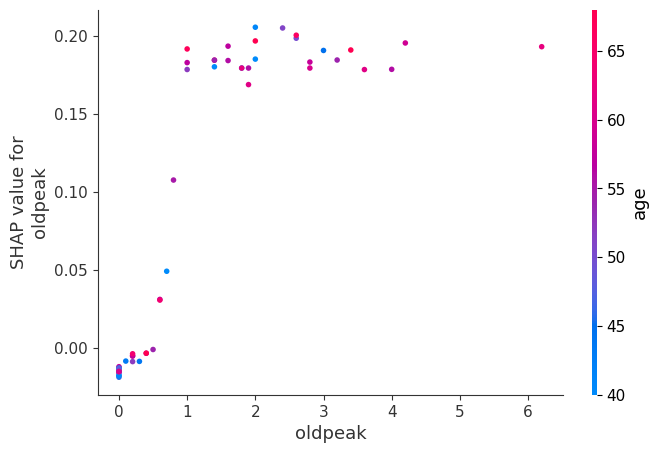

<Figure size 640x480 with 0 Axes>

In [10]:
shap.dependence_plot("oldpeak", shap_values[0], X_test,interaction_index="age")
plt.savefig('shap_summary_dependence_plot.png', bbox_inches='tight')

### Force Plot
- We will examine the first sample in the testing set to determine which features contributed to the "0" result. To do this, we will utilize a force plot and provide the expected value, SHAP value, and testing sample.

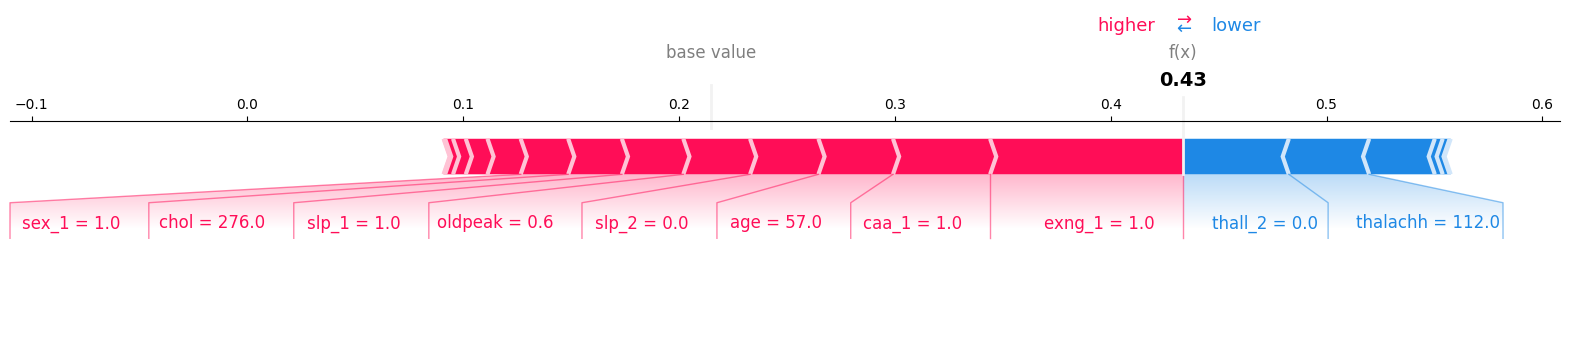

<Figure size 640x480 with 0 Axes>

In [11]:
shap.plots.force(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0, :], matplotlib = True)
plt.savefig('shap_force_plot.png', bbox_inches='tight')

## Decision Plot
-We will now display the decision_plot. It visually depicts the model decisions by mapping the cumulative SHAP values for each prediction.

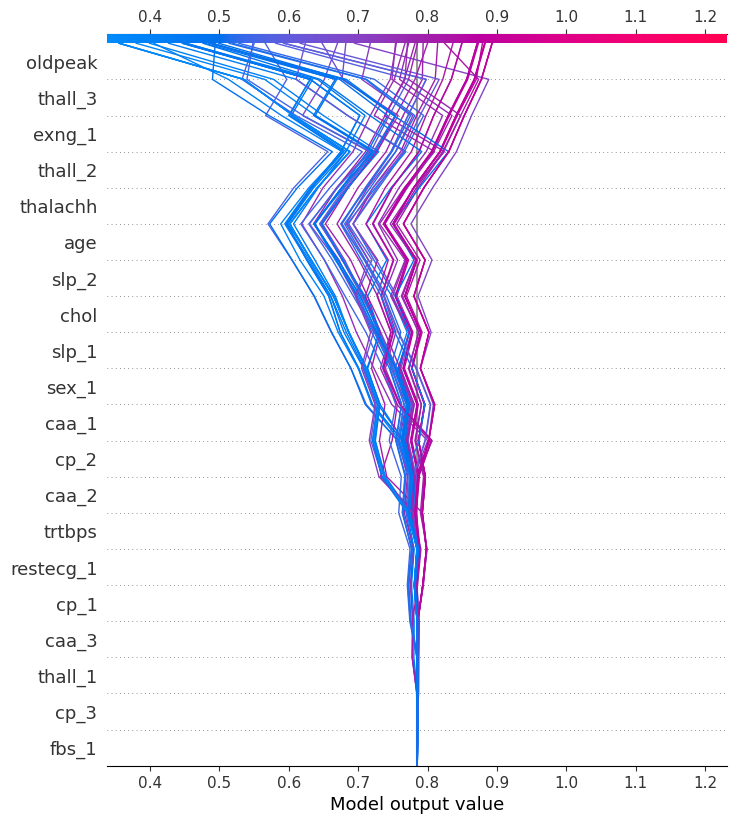

<Figure size 640x480 with 0 Axes>

In [12]:
shap.decision_plot(explainer.expected_value[1], shap_values[1], X_test.columns)
plt.savefig('shap_decision_plot.png', bbox_inches='tight')

In [13]:
# Load the saved model
loaded_model = joblib.load(model_name)

# Preprocess the new data using the saved preprocessing pipeline
preprocessed_data = loaded_model.named_steps['preprocessor'].transform(X_test)

# Make predictions using the loaded model
predict = loaded_model.predict(preprocessed_data)

# Get probability scores for each class
probability_scores = loaded_model.predict_proba(preprocessed_data)

acc = accuracy_score(y_test, predict)
conf = confusion_matrix(y_test, predict)

y_pred_proba = loaded_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test,y_pred_proba)

print(roc_auc)
print(acc)
print(conf)    
print(classification_report(y_test,predict))

0.9170258620689656
0.6885245901639344
[[12 17]
 [ 2 30]]
              precision    recall  f1-score   support

           0       0.86      0.41      0.56        29
           1       0.64      0.94      0.76        32

    accuracy                           0.69        61
   macro avg       0.75      0.68      0.66        61
weighted avg       0.74      0.69      0.66        61



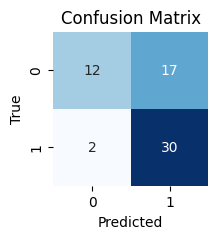

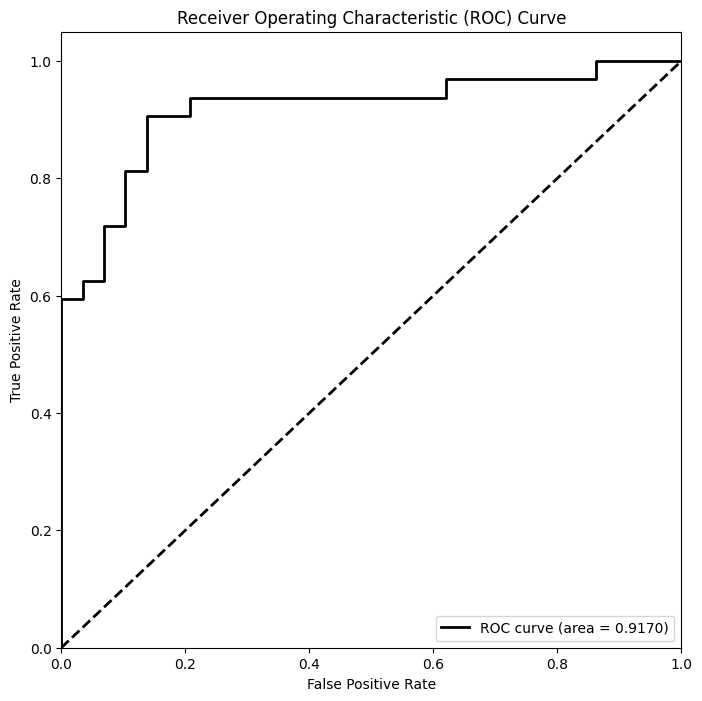

In [14]:
# Plot Confusion Matrix
plt.figure(figsize=(2,2))
sns.heatmap(conf, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

# Show the plot
plt.savefig("Confusion_Matrix.png",transparent=True,bbox_inches='tight',pad_inches=0.05,dpi=400) 
plt.show()

# Plot ROC Curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='black', lw=2, label='ROC curve (area = {:.4f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Show the plot
plt.savefig("ROC_Curve.png",transparent=True,bbox_inches='tight',pad_inches=0.05,dpi=400) 
plt.show()

Feature Importance
      Feature  Importance
4     oldpeak    0.165783
20    thall_2    0.133952
3    thalachh    0.114017
21    thall_3    0.099634
6      exng_1    0.099247
0         age    0.072940
2        chol    0.051058
18      slp_2    0.041254
7       caa_1    0.039992
5       sex_1    0.038460
1      trtbps    0.036172
17      slp_1    0.032316
12       cp_2    0.027711
8       caa_2    0.021072
15  restecg_1    0.011846
11       cp_1    0.007345
9       caa_3    0.003384
19    thall_1    0.002208
14      fbs_1    0.000962
13       cp_3    0.000647
10      caa_4    0.000000
16  restecg_2    0.000000


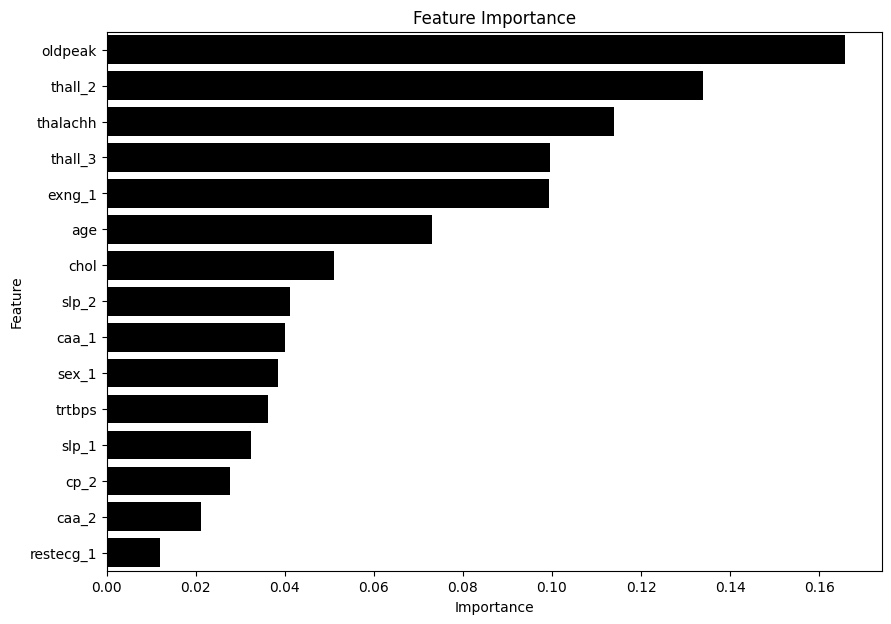

In [15]:
feature_importances = loaded_model.named_steps['classifier'].feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
sorted_df = importance_df.sort_values(by='Importance', ascending=False)
sorted_df = sorted_df.head(15)

# Print sorted feature importance
print(f"Feature Importance")
print(importance_df.sort_values(by='Importance', ascending=False))

 # Create seaborn bar plot
plt.figure(figsize=(10, 7))
sns.barplot(x='Importance', y='Feature', data=sorted_df, color='black')
plt.title(f"Feature Importance")

# Show the plot
plt.savefig("Feature_Importance.png",transparent=True,bbox_inches='tight',pad_inches=0.05,dpi=400) 
plt.show()

In [16]:
df = pd.DataFrame(X_test,columns= X_test.columns)
df['conversion'] = y_test

df['prob'] = y_pred_proba
df['round_prob'] = round(df['prob'],1)

# Convert 'round_prob' column to string
df['round_prob'] = df['round_prob'].astype(str)

df = df.groupby(['round_prob'])['conversion'].agg(['mean', 'count']).reset_index()
df['mean'] = df['mean']*100
df

,round_prob,mean,count
0,0.1,0.000000,1
1,0.2,20.000000,5
2,0.3,14.285714,7
3,0.4,0.000000,10
4,0.5,33.333333,3
5,0.6,50.000000,6
6,0.7,83.333333,6
7,0.8,66.666667,6
8,0.9,100.000000,12
9,1.0,100.000000,5


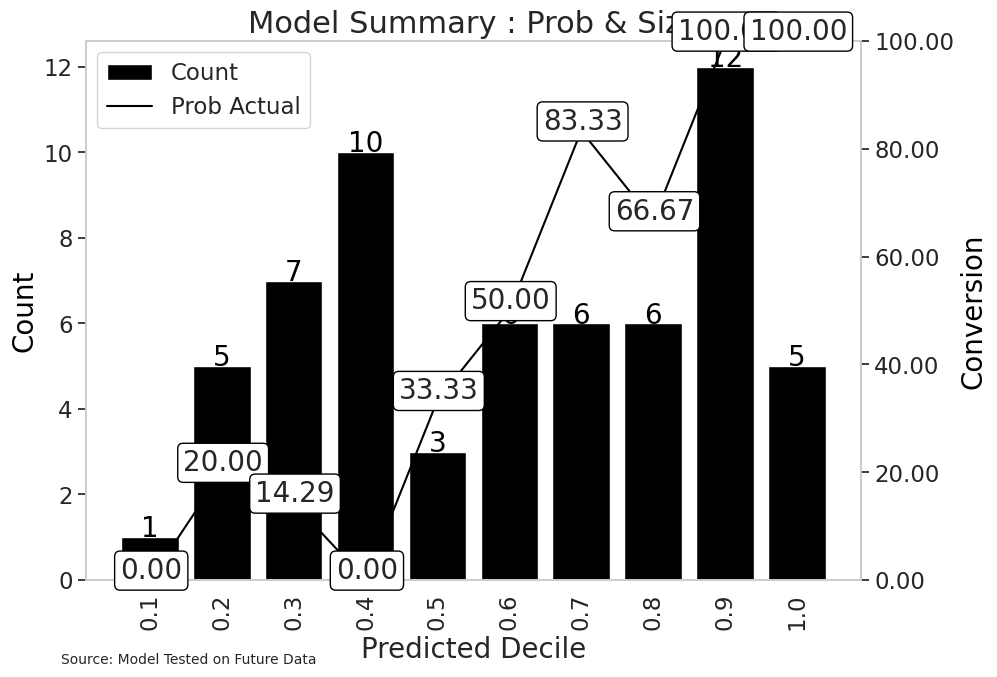

In [17]:
sns.set(style="whitegrid", font_scale=1.5)

# Create figure and axes
fig, ax1 = plt.subplots(figsize=(10, 7),frameon =False)

# Plot the bar chart on the primary y-axis
bar = sns.barplot(data=df, x='round_prob', y='count', ax=ax1, color='black')
ax1.set_ylabel('Count', color='black', fontsize=20)

# Add values on top of the bars
for i, v in enumerate(df['count']):
    ax1.text(i + 0.002, v + 0.002, '{:,.0f}'.format(v), color='black', ha='center',fontsize=20)

plt.xticks(rotation=90) 
ax2 = ax1.twinx()

# Plot the line chart on the secondary y-axis
line = sns.lineplot(data = df, x='round_prob', y='mean', ax=ax2, color='black')
ax2.set_ylim([0, 100])
ax2.set_ylabel('Conversion', color='black', fontsize=20)
ax2.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x)))

skip_count = 0  # Specify how many labels to skip
skip_label = 0  # Initialize skip_label counter

# Add values on top of the bars
for i, v in enumerate(df['mean']):
    if skip_label == 0:
        ax2.annotate(f'{v:,.2f}', xy=(i, v), xytext=(1, 1), ha='center', textcoords='offset points',bbox=dict(boxstyle='round,pad=0.2', edgecolor='black', facecolor='white'),fontsize=20) 
    
    skip_label = (skip_label + 1) % (skip_count + 1)    

# Set x-axis label and title
ax1.set_xlabel('Predicted Decile', fontsize=20)
ax1.set_title('Model Summary : Prob & Size', fontsize=22)
ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

# Create legend with proxy artists
legend_labels = ['Count', 'Prob Actual']
legend_elements = [Patch(facecolor='black', label='Bar Plot'),
                   Line2D([0], [0], color='black', label='Line Plot')]
plt.legend(handles=legend_elements, labels=legend_labels)

# Disable the background grid lines
ax1.grid(False)
ax2.grid(False)

# Adding a footnote below the x-axis
footnote_text = "Source: Model Tested on Future Data"
plt.figtext(0.1, -0.01, footnote_text, ha="left", fontsize=10, bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.3'))    

# Show the plot
plt.savefig("Prob_Size.png",transparent=True,bbox_inches='tight',pad_inches=0.05,dpi=400) 
plt.show()